In [1]:
import pandas as pd

df = pd.read_csv("netflix_reviews.csv")
df.drop(columns = ['reviewId', 'userName', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'appVersion'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117292 entries, 0 to 117291
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  117290 non-null  object
 1   score    117292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [2]:
df[df['content'].isnull()]

,content,score
7608,NaN,5
7959,NaN,2


In [3]:
df = df[~df['content'].isnull()]

In [4]:
df

,content,score
0,This App Not Supporting My Device ROG3 Mobile!...,1
1,"I'm getting very tired, you guys keep logging ...",2
2,One of my go to channels..l was at least 4 mov...,5
3,"Poor scripts, Violent content",2
4,Good,3
...,...,...
117287,i really like it! there are so many movies and...,5
117288,I love Netflix. I always enjoy my time using it.,5
117289,Sound quality is very slow of movies,1
117290,Rate is very expensive.. bcos we see netflix s...,1


In [5]:
import re

# 전처리 함수
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 대문자를 소문자로
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = text.strip()  # 띄어쓰기 제외하고 빈 칸 제거
    return text

df['cleaned_content'] = df['content'].apply(preprocess_text)

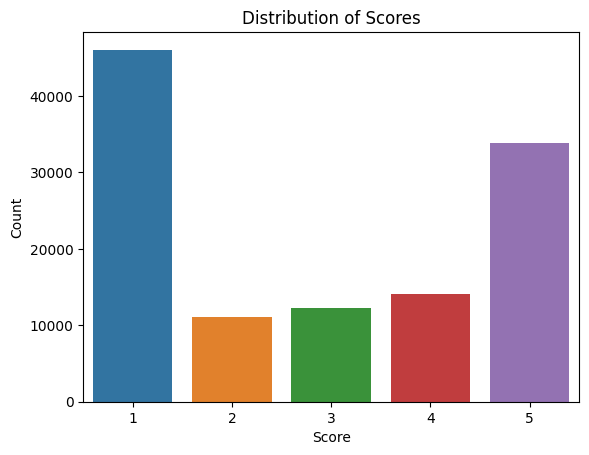

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

score_counts = df['score'].value_counts().sort_index()
sns.barplot(x=score_counts.index, y=score_counts.values)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Dataset(pytorch) : ReviewDataset()  
- 데이터셋의 구조를 정의. 배치 단위로 모델에 전달하기 쉽게 만듦.

주요 메서드 :  
1. __init__ : 생성자 메서드. 내부 변수 저장.  
2. __len__ : 데이터셋의 총 샘플 수 반환. DataLoader가 데이터 읽을 때 데이터의 크기를 알 수 있음(배치 나누는 기준).  
3. __getitem__ : 주어진 인덱스에 해당하는 데이터 샘플을 텐서 형태로 변환해 반환. DataLoader가 특정 인덱스 데이터를 가져갈 수 있도록.  

    토큰화 및 인덱스 변환 :  
    - self.tokenizer(review)로 단어 단위로 토큰화하여 리스트 형태로 반환.  
    - self.vocab으로 해당 단어를 정수 인덱스로 변환.  
    - 변환된 인덱스 리스트를 torch.tensor로 변환하여 review_tensor로 저장.  

    점수 텐서 변환 :  
    - score는 원래 정수, 실수로 구성되있어서 그냥 텐서 형태로 변환하고 타입만 float으로 설정해서 저장.  

반환 값은 review_tensor는 [sequence_length] 형태(정수 인덱스) 텐서, score_tensor는 스칼라 형태 실수 텐서.

1. tokenizer : 문장을 단어 단위로 분리하여 리스트형태로 반환.

2. vocab : reviews 데이터를 기준으로 단어를 추출해 단어 사전을 만든다.

In [8]:
reviews = df['cleaned_content'].tolist()
scores = df['score'].tolist()

# 토크나이저 생성.
tokenizer = get_tokenizer("basic_english")

# 단어 모음집 생성.
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# 리뷰 기준으로 모음집 내용 생성.
vocab = build_vocab_from_iterator(yield_tokens(reviews), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"]) # 없는 단어가 들어온다면 <unk>로 처리.

In [9]:
# 데이터셋 정의.
class ReviewDataset(Dataset):
    def __init__(self, reviews, scores, vocab, tokenizer):
        self.reviews = reviews  # 리뷰 내용 리스트
        self.scores = scores    # 점수 리스트
        self.vocab = vocab  # 단어 모음집
        self.tokenizer = tokenizer  # 토크나이저

    def __len__(self):
        return len(self.scores) # self.reviews로 대체 가능.(전체 길이)

    def __getitem__(self, idx):
        review = self.reviews[idx]  # 인덱스에 해당하는 리뷰의 내용과 점수.
        score = self.scores[idx]
        review_tensor = torch.tensor(self.vocab(self.tokenizer(review)), dtype=torch.long) # 텍스트를 토큰화 하여 단어 모음집를 통해 인덱스로 변환
        score_tensor = torch.tensor(score, dtype=torch.float)   # 점수 float 형태 텐서로 변환.
        return review_tensor, score_tensor

In [10]:
# 훈련, 테스트 데이터 분할 및 데이터셋 정의
train_reviews, test_reviews, train_scores, test_scores = train_test_split(reviews, scores, test_size=0.2, random_state=42)

train_dataset = ReviewDataset(train_reviews, train_scores, vocab, tokenizer)
test_dataset = ReviewDataset(test_reviews, test_scores, vocab, tokenizer)

# DataLoader(pytorch)  
- 큰 데이터를 미니배치로 나눠 반복적으로 모델에 전달하는 데 사용. 데이터셋을 불러오면서 자동으로 데이터를 섞거나 특정 규칙에 따라 배치 크기 조절 가능.  

주요 매개변수 :  
- dataset : Dataset 클래스에서 만든 train, test dataset 입력.  
- batch_size : 한 번에 학습할 데이터 개수.  
- shuffle : True면 각 에포크마다 데이터 순서가 무작위. 이로써 모델이 학습 데이터의 순서에 의존 X.  
- collate_fn : 각 배치를 어떻게 만들지 정의.  

# collate_batch  
- DataLoader에서 호출 후 데이터 가공. 리뷰마다 문장의 길이가 다르기 때문에 배치마다 길이를 맞춰야함. 그래서 pad_sequence 활용해 리뷰의 길이를 맞추고, 점수 데이터는 텐서 형태로 변환해서 모델에 입력.

순서 :  
- 배치 데이터 초기화 review_list, score_list.  
- 패딩 처리 :  
    nn.utils.rnn.pad_sequence : 텍스트의 시퀀스를 같은 길이로 맞추기 위해 패딩 추가.  
    batch_first = True : 출력 텐서의 첫 번째 차원을 배치 크기로, [batch_size, max_sequence_length] 형태로 변환.  
    padding_value=0 : 모든 데이터의 길이를 맞추기 위해 빈 곳은 0으로.  
- 점수 데이터 텐서 변환 :  
    torch.tensor()로 score_list를 float 타입의 텐서로 변환.(실수 형태로 예측할 값이기 때문에)  
- 반환 값 :  
    review_list는 [batch_size, max_sequence_length] 형태, score_list 는 [batch_size] 형태의 텐서.  


In [11]:
# DataLoader 정의 : 배치 단위로 불러옴.
def collate_batch(batch):   # 각 배치를 모델에 적합한 형태로 가공.
    review_list, score_list = [], []    # 배치 데이터 초기화(텍스트 시퀀스, 점수 저장)
    for text, score in batch:
        review_list.append(text)    # 배치 데이터를 돌아가며 각 텍스트와 점수를 리스트에 추가.
        score_list.append(score)

    # 패딩 처리
    review_list = nn.utils.rnn.pad_sequence(review_list, batch_first=True, padding_value=0)

    # 점수 데이터 텐서 변환
    score_list = torch.tensor(score_list, dtype=torch.float)

    return review_list, score_list

BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

# LSTM 모델 정의 : __init__ 메서드

1. 임베딩(embedding) 레이어 :  
    - 텍스트 데이터를 밀집 벡터로 변환. 패딩 토큰 등장 시 해당 위치 임베딩 적용 X.  
2. LSTM 레이어 :  
    - 입력된 텍스트의 순서 정보를 고려해 단어의 관계를 학습한다.  
    - batch_first=True는 입력 텐서의 첫 번째 차원이 배치 크기를 나타내도록 하여 데이터 형태가  
    [batch_size, sequence_length, embedding_dim]으로 맞춘다.  
    - bidirectional이 true면 양방향 학습으로 텍스트 앞뒤 문맥을 모두 활용함.  
3. 선형(fully connected, fc) 레이어 :  
    - 최종 LSTM 은닉 상태를 단일 출력값으로 변환.  

# forward 메서드  
- 입력 데이터 전달 후 예측 수행하는 함수.  

1. 임베딩 적용, 드롭아웃 :  
    - 입력된 리뷰를 임베딩 벡터로 변환하고, 드롭아웃을 적용.  
2. LSTM 연산 :  
    - 변환된 임베딩 벡터를 LSTM 레이어에 전달.  
    - hidden, cell은 마지막 스텝에서 은닉 상태와 셀 상태 반환.  
    - lstm_out은 모든 타입스텝 출력 예측, 여기서는 hidden만 사용해 출력 예측.  
3. fully connected 레이어 적용 :  
    - 최종 은닉 상태를 단일 예측값(모델 자체의 출력값)으로 변환.  

In [12]:
# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)   # 임베딩 레이어
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True) # LSTM 레이어
        self.fc = nn.Linear(hidden_dim, output_dim)    # 선형 레이어
        
    def forward(self, text):
        embedded = self.embedding(text)  # 임베딩 적용.
        lstm_out, (hidden, cell) = self.lstm(embedded)  # LSTM 연산
        return self.fc(hidden[-1]) # 마지막 히든 레이어 사용, 예측값 출력.

In [13]:
# 하이퍼파라미터 설정 및 모델 초기화(모델 크기, 구조 설정)
INPUT_DIM = len(vocab)  #단어 feature의 수
EMBEDDING_DIM = 100  # 워드벡터의 차원 수. 단어가 추상적으로 표현되는 크기
HIDDEN_DIM = 256    # 은닉층 차원 수(쉽게 말하면 모델의 일꾼)
OUTPUT_DIM = 1  # 단일 스칼라 값으로 회귀 예측.

In [14]:
model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 옵티마이저(optimizer)

1. optim.Adam(Adaptive Moment Estimation) :  
    학습 속도 자동 조절, 각 가중치에 대해 학습률을 적응적으로 조절하는 특징이 있다. 현재와 이전 기울기를 활용해 학습 속도를 조절하므로, SGD(stochastic Gradient Descent)보다 효율적.  
2. 매개변수(model.parameters()) :  
    학습 가능한 모델의 모든 파라키너(가중치, 편향)을 반환. 옵티마이저가 이 파라미터 업데이트하며 학습 진행.  

# 손실 함수(criterion)  

1. MSE(Mean Squared Error, 평균 제곱 오차) :  
    회귀 문제에 자주 사용하며, 예측값과 실제값의 차이를 모두 합해 제곱하여 평균을 구한다.  
2. 손실 함수의 역할 :  
    예측 값이 실제 값에서 얼마나 벗어났는지 나타냄. 값이 작으면 작을 수록 잘 예측하고 있는 것.  
    학습을 통해 손실을 줄이도록 가중치를 업데이트 하는 것이다.  

# GPU 활용  

torch.device는 계산할 장치를 정하는 것. cuda가 있으면 GPU, 그렇지 않으면 CPU 사용하도록 설정했다.  
GPU를 활용해야 딥러닝 모델 학습에 유리하다.  

model.to(device)는 모델의 가중치와 계산을 GPU로 이동한다.
crierion.to(device)는 손실 함수 계산을 GPU에서 할 수 있도록 이동. 학습 데이터 또한 같은 장치에서 계산되도록 해야한다.

In [15]:
# 손실 함수와 옵티마이저 정의
optimizer = optim.Adam(model.parameters()) # ADAM 옵티마이저 활용.
criterion = nn.MSELoss()  # MSE 손실 함수를 사용

# GPU 활용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # gpu 할당
model = model.to(device)
criterion = criterion.to(device)

# 모델 학습 및 평가

In [16]:
# 정확도 계산 함수 정의
def calculate_accuracy(predictions, score, tolerance):
    correct = (torch.abs(predictions - score) < tolerance).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [17]:
# 모델 학습 및 평가 함수
def train(model, iterator, optimizer, criterion, tolerance):
    epoch_loss = 0  # 한 에포크당 총 손실의 누적 변수
    epoch_acc = 0
    model.train()   # 학습 모드
    
    for text, score in iterator:    # train_loader로부터 미니배치 단위 (review, score)로 학습 데이터 가져옴.
        text, score = text.to(device), score.to(device) #GPU로 이동.
        
        optimizer.zero_grad()   # 이전 단계 기울기 초기화.
        predictions = model(text).squeeze(1)    # 모델에 텍스트 입력, 예측 수행. squeeze(1)은 불필요한 차원 제거.
        
        loss = criterion(predictions, score)    # 예측값, 실제값 손실 계산.
        
        acc = calculate_accuracy(predictions, score, tolerance)     # 정확도 계산.

        loss.backward() # 역전파 수행. 손실 통해 기울기 계산.
        optimizer.step()    # 옵티마이저로 가중치 업데이트.
        
        epoch_loss += loss.item()   # 미니 배치 손실을 에포크 손실에 누적.
        epoch_acc += acc.item() # 정확도를 에포크 정확도에 누적.
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)   # 에포크의 평균 손실, 정확도 반환.

In [18]:
def evaluate(model, iterator, criterion, tolerance):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()    # 평가 모드, dropout 비활성화.
    
    with torch.no_grad():   # 역전파 비활성화, 기울기 계산 비활성화. 메모리 사용량 감소, 연산 속도 증가.
        for text, score in iterator:
            text, score = text.to(device), score.to(device)

            predictions = model(text).squeeze(1)
            
            loss = criterion(predictions, score)
            
            acc = calculate_accuracy(predictions, score, tolerance)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)  # 최종적으로 한 에포크의 평균 손실 반환.

In [19]:
# 모델 학습 및 평가 실행
EPOCHS = 5
tolerance = 0.5

for epoch in range(EPOCHS):
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion, tolerance)
    test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, tolerance)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy*100:.2f}%, Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy*100:.2f}%')

Epoch: 01, Train Loss: 2.926, Train Accuracy: 10.51%, Test Loss: 2.936, Test Accuracy: 10.15%
Epoch: 02, Train Loss: 1.630, Train Accuracy: 30.08%, Test Loss: 1.085, Test Accuracy: 48.65%
Epoch: 03, Train Loss: 0.962, Train Accuracy: 50.35%, Test Loss: 0.964, Test Accuracy: 50.36%
Epoch: 04, Train Loss: 0.832, Train Accuracy: 54.76%, Test Loss: 0.978, Test Accuracy: 55.84%
Epoch: 05, Train Loss: 0.740, Train Accuracy: 58.01%, Test Loss: 0.968, Test Accuracy: 50.95%


# 새 리뷰 점수 예측

In [20]:
def predict_review(review, model, vocab, tokenizer, device):
    model.eval()  # 평가 모드로 전환
    tokens = tokenizer(review.lower())  # 리뷰 토큰화
    token_ids = [vocab[token] for token in tokens]  # 각 토큰을 고유 정수 인덱스로 변환. vocab.set_default_index(vocab["<unk>"])로 인해 토큰이 없다면 <unk>로 변환
    text_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(device)  # 위 ids를 텐서 변환하여 모델에 입력할 수 있게 하고 unsqueeze(0)를 통해 배치 차원 추가. 모델이 배치 단위로 입력 받기 때문에 [batch_size, sequence_length]형태로 맞추기 위해.
    
    with torch.no_grad():
        prediction = model(text_tensor).squeeze(1)  # 입력 텐서 모델에 넣어 예측 수행. 출력은 [batchsize, 1]형태로 점수가 나와서, squeeze(1)로 예측값만 가져옴.
        
    return prediction.item()  # 예측된 점수를 스칼라 형태로 반환

In [21]:
# 새로운 리뷰 예측
new_review = "It's disgusting."
predicted_score = predict_review(new_review, model, vocab, tokenizer, device)
print(f"Predicted score for the review: {predicted_score:.2f}")

Predicted score for the review: 0.86


In [22]:
new_review = "This is the greatest movie the world has ever seen."    #대문자는 predict_review 함수에서 소문자로 변형.
predicted_score = predict_review(new_review, model, vocab, tokenizer, device)
print(f"Predicted score for the review: {predicted_score:.2f}")

Predicted score for the review: 4.09
